From https://github.com/bhpfelix/Variational-Autoencoder-PyTorch/blob/master/src/vanila_vae.py

In [293]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import time
from glob import glob
# from util import *
import numpy as np
from PIL import Image

train_loader = range(1)

class VAE(nn.Module):
    def __init__(self, input_size, latent_variable_size):
        super(VAE, self).__init__()

        self.input_size = input_size
        self.latent_variable_size = latent_variable_size
        encoder_output_size = latent_variable_size

        # encoder
        self.e1 = nn.Linear(input_size, encoder_output_size)
        self.e2 = nn.Linear(encoder_output_size, encoder_output_size)

        self.fc1 = nn.Linear(encoder_output_size, latent_variable_size)
        self.fc2 = nn.Linear(encoder_output_size, latent_variable_size)

        # decoder
        self.d1 = nn.Linear(latent_variable_size, encoder_output_size)
        self.d2 = nn.Linear(encoder_output_size, input_size)

        self.dropout = nn.Dropout(p=0.2)
        self.leakyrelu = nn.LeakyReLU(0.2)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        x = self.relu(self.e1(x))
        x = self.relu(self.e2(x))

        return self.fc1(x), self.fc2(x)

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        #if args.cuda:
        #    eps = torch.cuda.FloatTensor(std.size()).normal_()
        #else:
        eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        h1 = self.relu(self.d1(z))
        h2 = self.relu(self.d2(h1))

        return self.sigmoid(h2)

    def get_latent_var(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        return z

    def forward(self, x):
        mu, logvar = self.encode(x)
        #print("mu ", mu)
        #print("logvar ", logvar)
        z = self.reparametrize(mu, logvar)
        #print("z ", z)
        res = self.decode(z)
        #print("res ", res)
        return res, mu, logvar

# if args.cuda:
#     model.cuda()

reconstruction_function = nn.BCELoss()
reconstruction_function.size_average = False
def loss_function(recon_x, x, mu, logvar):
    BCE = reconstruction_function(recon_x, x)

    # https://arxiv.org/abs/1312.6114 (Appendix B)
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)

    return BCE + KLD


In [294]:
from scipy.ndimage.filters import gaussian_filter
import numpy as np
def generate_frames1(width, height):
    gutter = 10

    frames = []

    for y in range(gutter-5, gutter+height-5):
        for x in range(width+2*gutter):
            frame = np.zeros((width + 2 * gutter, height + 2 * gutter))
            frame[y:10+y, x:x+3] = 1
            frame=gaussian_filter(frame, 0.5)
            clipped = frame[gutter:-gutter, gutter:-gutter]
            frames.append(clipped)

    return np.asarray(frames)

def generate_frames(width, height):
    return np.asarray([[[0, 0], [1, 1]], [[1, 1], [0, 0]]])

width = 2
height = 2
X = generate_frames(width, height)
X = X.reshape(-1, height * width)
X = torch.Tensor(X)

model = VAE(height * width, latent_variable_size=1)
print(model)

VAE(
  (e1): Linear(in_features=4, out_features=1, bias=True)
  (e2): Linear(in_features=1, out_features=1, bias=True)
  (fc1): Linear(in_features=1, out_features=1, bias=True)
  (fc2): Linear(in_features=1, out_features=1, bias=True)
  (d1): Linear(in_features=1, out_features=1, bias=True)
  (d2): Linear(in_features=1, out_features=4, bias=True)
  (dropout): Dropout(p=0.2)
  (leakyrelu): LeakyReLU(negative_slope=0.2)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)


torch.Size([2, 4])


/Users/amolk/work/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


====> Epoch: 999 Average loss: 0.6972


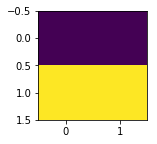

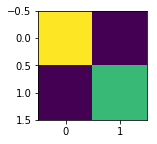

====> Epoch: 1999 Average loss: 0.6931


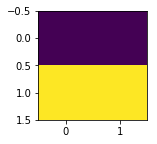

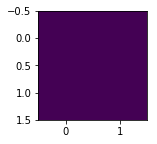

====> Epoch: 2999 Average loss: 0.6931


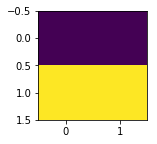

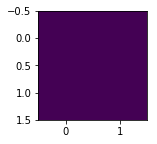

====> Epoch: 3999 Average loss: 0.6931


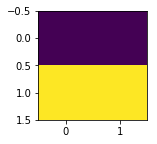

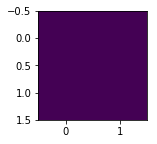

====> Epoch: 4999 Average loss: 0.6931


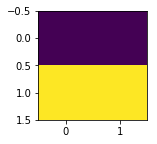

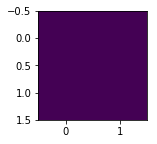

====> Epoch: 5999 Average loss: 0.6931


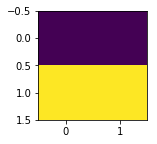

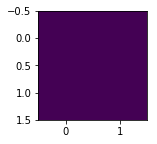

====> Epoch: 6999 Average loss: 0.6931


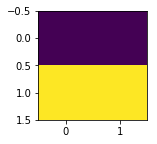

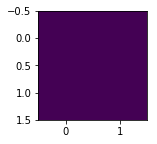

====> Epoch: 7999 Average loss: 0.6931


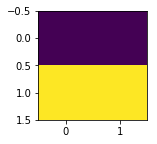

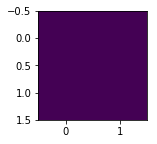

====> Epoch: 8999 Average loss: 0.6931


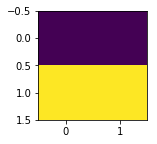

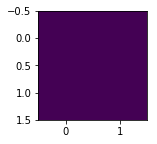

====> Epoch: 9999 Average loss: 0.6931


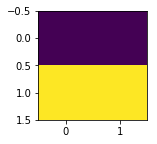

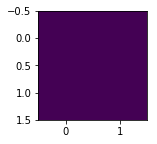

In [298]:
import matplotlib.pyplot as plt
%matplotlib inline

optimizer = optim.Adam(model.parameters(), lr=1e-3)

def show_image(image, vmin=None, vmax=None, title=None, print_values=False):
    #print("image ", image.shape)
    fig, ax1 = plt.subplots(figsize=(6, 2))
    if title:
        plt.title(title)
    #i = image.reshape((height, width))
    #print("i ", i.shape)
    ax1.imshow(image, vmin=vmin, vmax=vmax)
    plt.show()
    if print_values:
        print(image)
    
def train(epoch, X):
    model.train()
    train_loss = 0
    optimizer.zero_grad()
    recon_batch, mu, logvar = model(X)
    loss = loss_function(recon_batch, X, mu, logvar)
    loss.backward()
    train_loss += loss.data[0]
    optimizer.step()

    if (epoch+1) % 1000 == 0:
        print('====> Epoch: {} Average loss: {:.4f}'.format(
              epoch, train_loss))
        show_image(X[0].numpy().reshape(width, height))
        show_image(recon_batch[0].detach().numpy().reshape(width, height))


    return train_loss / (len(train_loader)*128)

print(X.shape)
for epoch in range(10000):
    train(epoch, X)

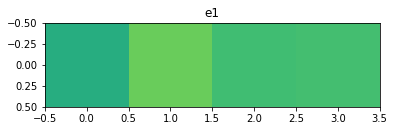

[[0.24421954 0.54299337 0.38531336 0.40290013]]


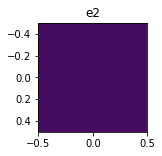

[[-0.9372702]]


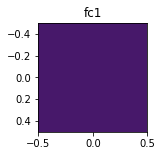

[[-0.8712742]]


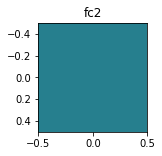

[[-0.13669647]]


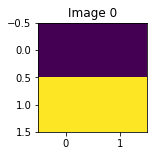

[[0. 0.]
 [1. 1.]]


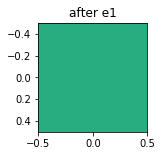

[[0.6229476]]


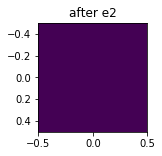

[[0.]]


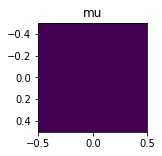

[[-4.64e-43]]


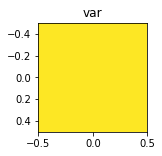

[[1.]]


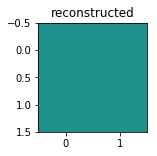

[[0.5 0.5]
 [0.5 0.5]]


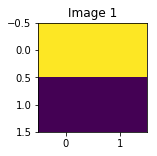

[[1. 1.]
 [0. 0.]]


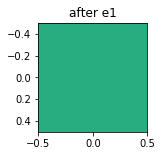

[[0.62194705]]


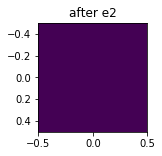

[[0.]]


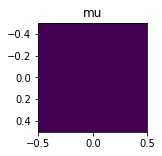

[[-4.64e-43]]


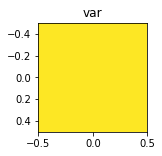

[[1.]]


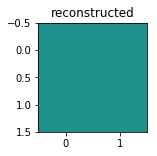

[[0.5 0.5]
 [0.5 0.5]]


In [302]:
show_image(model.e1.weight.detach().numpy(), print_values=True, vmin=-1, vmax=1, title="e1")
show_image(model.e2.weight.detach().numpy(), print_values=True, vmin=-1, vmax=1, title="e2")
show_image(model.fc1.weight.detach().numpy(), print_values=True, vmin=-1, vmax=1, title="fc1")
show_image(model.fc2.weight.detach().numpy(), print_values=True, vmin=-1, vmax=1, title="fc2")

for i in range(2):
    show_image(X[i].detach().numpy().reshape(height, width), print_values=True, vmin=0, vmax=1, title=f"Image {i}")
    #show_image(model(X[5])[1].detach().numpy().reshape(1, 10))
    #show_image(model(X[5])[0].detach().numpy().reshape(height, width))
    x = model.relu(model.e1(X[i]))
    show_image(x.detach().numpy().reshape(1, 1), print_values=True, vmin=0, vmax=1, title="after e1")
    x = model.relu(model.e2(x))
    show_image(x.detach().numpy().reshape(1, 1), print_values=True, vmin=0, vmax=1, title="after e2")

    
    rec, mu, logvar = model(X[i])
    rep = model.reparametrize(mu, logvar)
    show_image(mu.detach().numpy().reshape(1,1), print_values=True, vmin=0, vmax=1, title="mu")
    show_image(logvar.exp().detach().numpy().reshape(1,1), print_values=True, vmin=0, vmax=1, title="var")
    show_image(rec.detach().numpy().reshape(height, width), print_values=True, vmin=0, vmax=1, title="reconstructed")
    
    #d = torch.FloatTensor(100).normal_()
    #show_image(d.detach().numpy().reshape(10,10))
    pass



Abandoning the use of VAE, can't get it to work on even tiny inputs. Instead I'll next try a a single layer convnet and finding distribution of z using a batch of noisy variations of input where each pixel would be sampled using normal distribution with static variance.